In [4]:
from pymongo import MongoClient,TEXT
import matplotlib.pyplot as plt
import urllib.parse
import pandas as pd
import urllib.robotparser
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
import time 
import nltk
from dateutil import parser
from nltk.corpus import stopwords
nltk.download('stopwords')
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/linuxperso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
client=MongoClient('localhost', port=27017)
performance={}
database="scrapping"
collection_sitemaps="sitemaps"
collection_htmls="htmls"

In [3]:
print("\nNb pages html :{}".format(client[database][collection_htmls].count_documents({})))


Nb pages html :1353114


La requête count_documents est lente car mongo doit tout parcourir 

In [4]:
list(client[database][collection_htmls].aggregate(
                                                    [ { "$sample": { "size": 5 } } ]
                                                    ))

[{'_id': ObjectId('65b02e4359b614dc3a0428a7'),
  'url': 'https://www.washingtonexaminer.com/tag/brett-baier/',
  'mots_in_url': ['tag', 'brett', 'baier'],
  'has_been_scrapped': False,
  'id_media': 2917,
  'media_name': 'Washington Examiner',
  'is_responding': True,
  'xml_source': 'https://www.washingtonexaminer.com/generated-sitemaps/post_tag-sitemap3.xml',
  'date_day': datetime.datetime(2023, 10, 6, 0, 0),
  'date': datetime.datetime(2023, 10, 6, 12, 48),
  'text': None},
 {'_id': ObjectId('65b02e4359b614dc3a043615'),
  'url': 'https://www.washingtonexaminer.com/tag/latin-america/',
  'mots_in_url': ['tag', 'latin', 'america'],
  'has_been_scrapped': False,
  'id_media': 2917,
  'media_name': 'Washington Examiner',
  'is_responding': True,
  'xml_source': 'https://www.washingtonexaminer.com/generated-sitemaps/post_tag-sitemap3.xml',
  'date_day': datetime.datetime(2023, 12, 23, 0, 0),
  'date': datetime.datetime(2023, 12, 23, 10, 19),
  'text': None},
 {'_id': ObjectId('65b02c075

In [6]:
source_day_df=pd.DataFrame(list(client[database][collection_htmls].aggregate([
    {
        "$group" : {"_id":{"date_day":"$date_day","media_name":"$media_name"}, "count":{"$sum":1}}
        },
    {
        "$project" : 
        {
            "_id":0,
            "date_day":"$_id.date_day",
            "media_name":"$_id.media_name",
            "count":"$count"
        }
    }
])))
source_day_df

,date_day,media_name,count
0,2023-09-12,TPM,8
1,2024-01-22,NBC Montana,5
2,2022-08-17,Daily Beast,80
3,2023-02-24,News Blaze,1
4,2020-02-09,Monsters and Critics,9
...,...,...,...
46574,2019-09-11,Washington Jewish Week,16
46575,2009-06-10,Congress Heights on the Rise,7
46576,2021-06-06,Congress Heights on the Rise,8
46577,2009-10-10,Congress Heights on the Rise,4


In [14]:
#pourcentage=source_day_df.loc[:, ["date_day","media_name", "count"]].groupby(by="media_name", as_index=True).apply(lambda df:df.loc[:, "count"]/sum(df.loc[:, "count"])).reset_index().drop(columns=['level_1', "media_name"]).rename(columns={"count":"pourcent"})
#sorted_by_day=pd.concat([source_day_df,pourcentage], axis=1).sort_values(by=["pourcent", "media_name"], ascending=False)
#sorted_by_day
#pourcentage
import numpy as np
remove_bad_date=source_day_df.groupby("media_name").apply(lambda df:pd.Series({"moyenne_article_par_jour":np.array(list(df.loc[:,"count"])).mean(), 
                                                               "nb_articles":np.array(list(df.loc[:,"count"])).sum(), 
                                                               "nb_jours":len(df)})).sort_values(by="moyenne_article_par_jour",ascending=False).iloc[:55]
remove_bad_date

,moyenne_article_par_jour,nb_articles,nb_jours
media_name,,,
Christian Science Monitor,105014.000000,105014.0,1.0
Op Ed News,88948.000000,88948.0,1.0
Washington City Paper,16000.000000,16000.0,1.0
GW Hatchet,16000.000000,16000.0,1.0
American Prospect,12009.000000,12009.0,1.0
Diario Digital,8442.000000,8442.0,1.0
Online Journal,7665.000000,7665.0,1.0
Hollywood Weekly,5762.000000,5762.0,1.0
American Free Press,5630.000000,5630.0,1.0


In [13]:
list(remove_bad_date.loc[(remove_bad_date.loc[:, "nb_jours"]<=3), :].index)

['Christian Science Monitor',
 'Op Ed News',
 'Washington City Paper',
 'GW Hatchet',
 'American Prospect',
 'Diario Digital',
 'Online Journal',
 'Hollywood Weekly',
 'American Free Press',
 'Southwester',
 'MSN',
 'CBS Sports',
 'The Source',
 'Access Hollywood',
 'Associated Press',
 'New Republic',
 'Guardian',
 'Livingston Enterprise',
 'NBC Sports',
 'PBS News Hour',
 'Reuters',
 'ESPN',
 'Las Americas',
 'Us',
 'RTT News',
 'Sanders County Ledger',
 'Univision',
 'The Conversation']

In [112]:
sorted_by_day.loc[:, ["media_name","pourcent"]].groupby(by="media_name").apply(lambda df:df.mean()).sort_values(by="pourcent",ascending=False)

,pourcent
media_name,
CNN,0.166556
Hot Joints,0.070329
Vox,0.025337
Mic,0.023987
Columbia Heights Insider,0.021276
...,...
Online Journal,0.000167
GW Hatchet,0.000136
The Conversation,0.000122


In [185]:
client[database][collection_htmls].create_index('mots_in_url')

'mots_in_url_1'

# Requete avec uniquement le match sur les éléments de l'array parsé

In [1]:
t1=time.time()
list_match=["energy", "climate"]#"france"#"climat"#"cop.?28"
list_no_match=[]
all=False

def match_document_v1(client, database, collection_htmls, list_match, all=False):
    if all:
        print("all element in list_match")
        return pd.DataFrame(list(client[database][collection_htmls].aggregate(
                                                        [
                                                            {
                                                                "$match" : 
                                                                {
                                                                    "$and":
                                                                        [
                                                                        {"mots_in_url": { "$all":  list_match }},
                                                                        {"mots_in_url": { "$nin":  list_no_match }}
                                                                        ]

                                                                },
                                                            },
                                                            { "$project": 
                                                                    { 
                                                                        "_id":0,
                                                                        "id_media": 1, 
                                                                        "media_name": 1, 
                                                                        "url" : 1, 
                                                                        "mots_in_url" :1,
                                                                        "xml_source" :1,
                                                                        "date_day":1,
                                                                        "date":1
                                                                    }
                                                            }
                                                        ]
                                                )
                                        )
        )
    else:
        print("one element atleast in list_match")
        return  pd.DataFrame(list(client[database][collection_htmls].aggregate(
                                                            [
                                                                {
                                                                    "$match" : 
                                                                    {
                                                                        "$and":
                                                                            [
                                                                            {"mots_in_url": { "$in":  list_match }},
                                                                            { "mots_in_url": { "$nin":  list_no_match }}
                                                                            ]

                                                                    },
                                                                },
                                                                { "$project": 
                                                                        { 
                                                                            "_id":0,
                                                                            "id_media": 1, 
                                                                            "media_name": 1, 
                                                                            "url" : 1, 
                                                                            "mots_in_url" :1,
                                                                            "xml_source" :1,
                                                                            "date_day":1,
                                                                            "date":1
                                                                        }
                                                                }
                                                            ]
                                                    )
                                            )
            )


df_urls_match_v1=match_document_v1(client, database, collection_htmls, list_match, all=all)
t2=time.time()
print(t2-t1)
print(len(df_urls_match_v1))
performance["match_sur_element_only"]=[len(df_urls_match_v1),t2-t1]

NameError: name 'time' is not defined

In [204]:
df_urls_match_v1.sample(2).loc[:, ["url", "xml_source", "mots_in_url"]]

,url,xml_source,mots_in_url
23646,https://www.thedailybeast.com/trump-got-a-kick-out-of-the-election-fears-hes-stoked-inside-the-doj-theres-some-panic,https://www.thedailybeast.com/sitemap-7.xml,"[trump, got, kick, election, fears, hes, stoked, inside, doj, theres, panic]"
14953,https://www.thebulwark.com/podcast-episode/tom-nichols-on-trump-and-superman/,https://www.thebulwark.com/podcast-episode-sitemap.xml,"[podcast, episode, tom, nichols, trump, superman]"


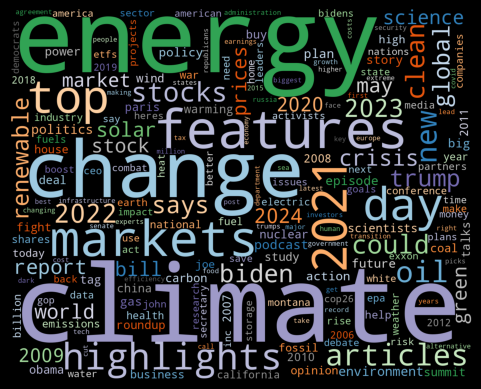

In [8]:
n=200
liste_parser=list(df_urls_match_v1.loc[:, "mots_in_url"].dropna())
series_word_freq = pd.Series([ x for xs in liste_parser for x in xs ]).value_counts().reset_index()
dictio_frequence=dict(zip(series_word_freq.loc[:, "index"], series_word_freq.loc[:, "count"]))

#medias à ignorer
figure, axes = plt.subplots(1, 1, facecolor='k')
wcloud = WordCloud(width=1500, height=1200,  colormap='tab20c').generate_from_frequencies(dictio_frequence)
axes.imshow(wcloud)
axes.axis("off")
plt.show()


In [9]:
n=5
series_word_freq = pd.Series([ x for xs in liste_parser for x in xs ]).value_counts().reset_index().iloc[1:n+1]
series_word_freq
for k in list(series_word_freq.loc[:, "index"]):
    print(k)
    print(pd.Series([ x for xs in list(filter(lambda x:k in x, liste_parser)) for x in xs ]).value_counts().reset_index().iloc[2:n+2])

energy
        index  count
2         top    574
3     markets    562
4         day    553
5  highlights    528
6        2021    347
change
      index  count
2      2021    139
3  articles    100
4      2023     93
5       new     76
6     could     70
features
        index  count
2         day    534
3  highlights    528
4         top    528
5     roundup    100
6         oil     71
markets
      index  count
2   climate    135
3    stocks     75
4     stock     67
5     today     59
6  partners     51
2021
     index  count
2  climate    323
3   change    141
4   stocks     92
5     says     65
6    clean     46


In [10]:


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD


print(len(liste_parser))

vectorizer_url= TfidfVectorizer()
tfidf_matrix = vectorizer_url.fit_transform(list(map(lambda x:" ".join(x),liste_parser)))

lsa = TruncatedSVD(n_components=2)
lsa_matrix = lsa.fit_transform(tfidf_matrix)

# Perform K-Means clustering
k = 2  # Number of clusters (based on the 20 Newsgroups categories)
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(tfidf_matrix)

# Visualize the clusters
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

"""
plt.figure(figsize=(10, 8))
plt.scatter(lsa_matrix[:, 0], lsa_matrix[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1,], s=200, c='red')
plt.title("Text Clustering with K-Means")
plt.show()"""
import plotly.graph_objects as go
fig = go.Figure()

print(lsa_matrix.shape)
fig.add_trace(go.Scatter(
    x=lsa_matrix[:, 0],
    y=lsa_matrix[:, 1],
    mode='markers',
    customdata=list(map(lambda x:" ".join(x),liste_parser)),
    hovertemplate="%{customdata}",
    marker=dict(color=labels)
))



fig.update_layout(
    width=1000,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=20,
        t=20,
        pad=4
    ),
)


fig.show()

8452
(8452, 2)
